In [28]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
import geopandas as gpd
import numpy as np
from pyproj import CRS
import pandas as pd
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [29]:
# essentially, transforms a time series dataset into a format suitable
# for predictive modeling by shifting past observations as features

# check here if you need help / have questions: https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/

def create_lag_features(data, n_in=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # Input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('%s(t-%d)' % (df.columns[j], i)) for j in range(n_vars)]
    # Forecast sequence (t)
    cols.append(df[['Latitude', 'Longitude']])
    names += ['Latitude(t)', 'Longitude(t)']
    # Put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # Drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [30]:
data_path = 'data/atlantic_post2003.csv'
data = pd.read_csv(data_path)

In [31]:
features = ['Maximum Wind', 'Minimum Pressure', 'Latitude', 'Longitude']
data_filtered = data[features].ffill()  # .fillna is deprecated lol

scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data_filtered)
n_in = 5
data_lagged = create_lag_features(pd.DataFrame(data_scaled, columns=features), n_in=n_in)

# splitting
num_features = len(features)
X = data_lagged.iloc[:, :-(num_features * n_in)]  # hopefully should prevent leakage of current values into the model lmao
y = data_lagged[['Latitude(t)', 'Longitude(t)']]  # target vals

train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

In [32]:
# params from our gridsearch
rf_model = RandomForestRegressor(
    n_estimators=300,
    max_depth=None,
    min_samples_leaf=4,
    min_samples_split=2,
    random_state=42
)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean squared error: {mse}')

Mean squared error: 0.029108533618830226


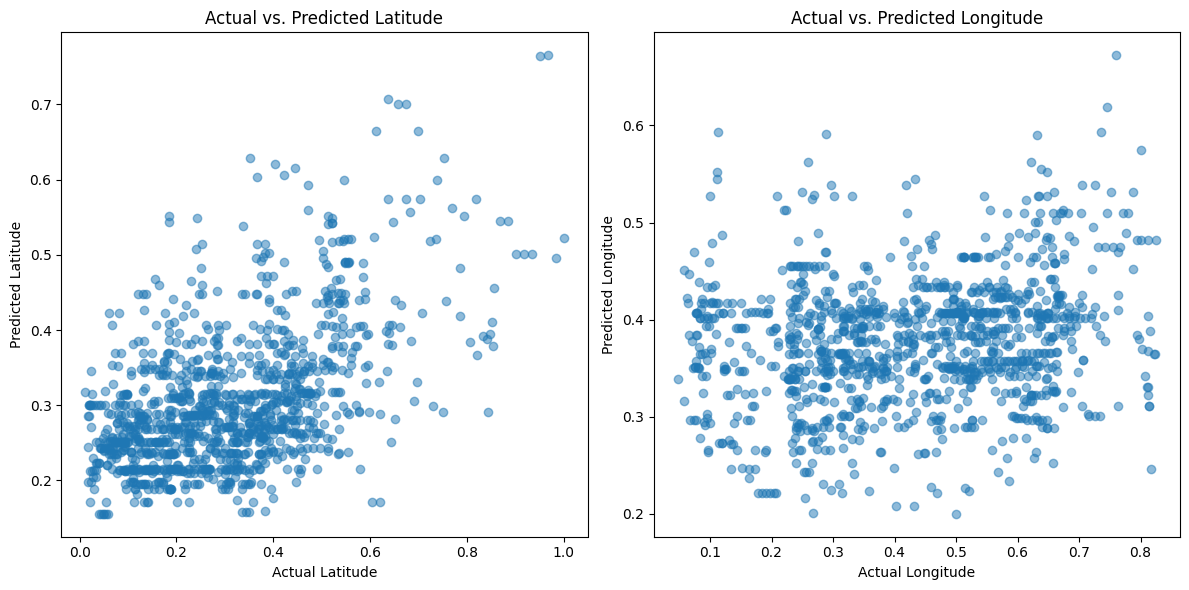

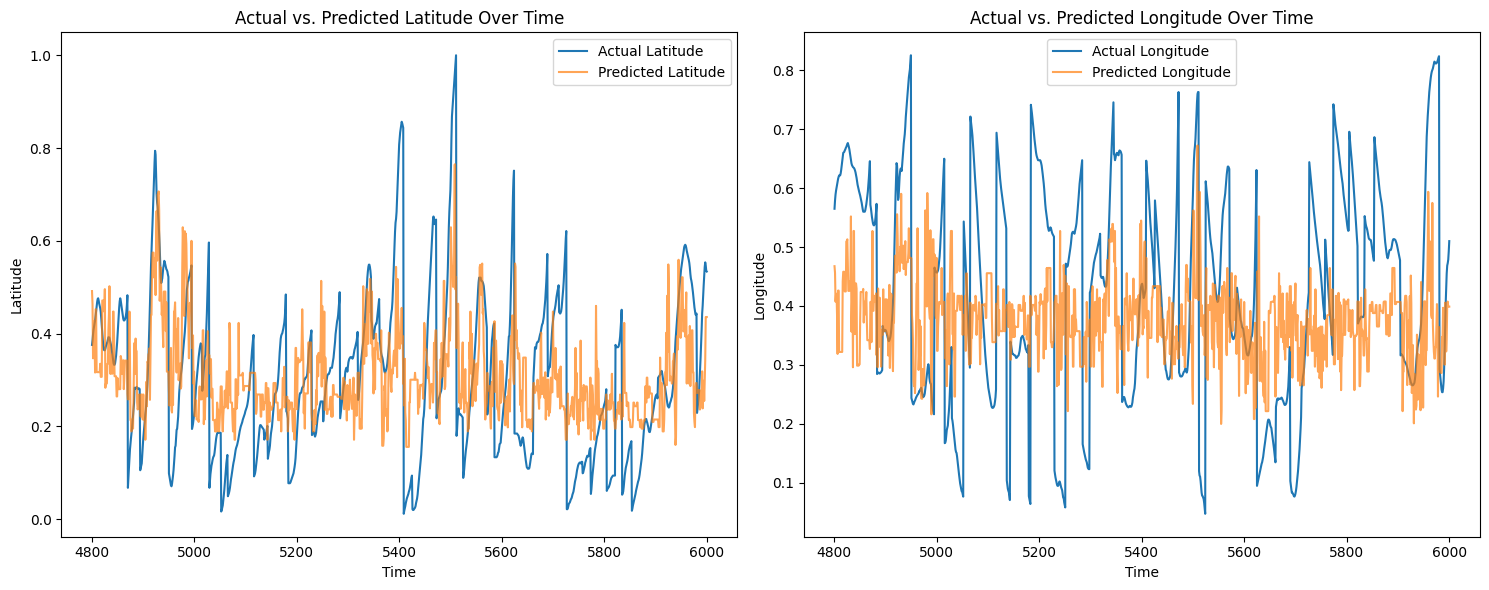

In [33]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(y_test['Latitude(t)'], y_pred[:, 0], alpha=0.5)
plt.title('Actual vs. Predicted Latitude')
plt.xlabel('Actual Latitude')
plt.ylabel('Predicted Latitude')

plt.subplot(1, 2, 2)
plt.scatter(y_test['Longitude(t)'], y_pred[:, 1], alpha=0.5)
plt.title('Actual vs. Predicted Longitude')
plt.xlabel('Actual Longitude')
plt.ylabel('Predicted Longitude')

plt.tight_layout()
plt.show()


plt.figure(figsize=(15, 6))

# should probably replace index with datetime at some point
plt.subplot(1, 2, 1)
plt.plot(y_test.index, y_test['Latitude(t)'], label='Actual Latitude')
plt.plot(y_test.index, y_pred[:, 0], label='Predicted Latitude', alpha=0.7)
plt.title('Actual vs. Predicted Latitude Over Time')
plt.xlabel('Time')
plt.ylabel('Latitude')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(y_test.index, y_test['Longitude(t)'], label='Actual Longitude')
plt.plot(y_test.index, y_pred[:, 1], label='Predicted Longitude', alpha=0.7)
plt.title('Actual vs. Predicted Longitude Over Time')
plt.xlabel('Time')
plt.ylabel('Longitude')
plt.legend()

plt.tight_layout()
plt.show()

In [34]:
# initial 5 data points for hurricane Katrina
initial_data = {
    'Maximum Wind(t-5)': [30, 30, 35, 40, 45], 
    'Minimum Pressure(t-5)': [1008.0, 1007.0, 1006.0, 1003.0, 1000.0], 
    'Latitude(t-5)': [23.1, 23.4, 23.8, 24.5, 25.4],
    'Longitude(t-5)': [-75.1, -75.7, -76.2, -76.5, -76.9]
}
initial_data_df = pd.DataFrame(initial_data)


# TODO: Fill missing values using our model we made (rf_model)

# TODO: and put them in a df called predicted_path_df

In [35]:

# TODO: Maybe model it using the geopandas library. I set up some code below that should model the predicted path

# TODO: it worked with manual values, but I'm not sure if it will work with the predicted values once we get them

"""
predicted_path_df['geometry'] = predicted_path_df.apply(lambda row: Point(row['Longitude'], row['Latitude']), axis=1)
gdf = gpd.GeoDataFrame(predicted_path_df, geometry='geometry')

# basic world map
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

fig, ax = plt.subplots(figsize=(15, 10))
world.plot(ax=ax, color='white', edgecolor='black')
gdf.plot(ax=ax, color='red', marker='o', markersize=50)  # Plotting the predicted path

plt.title('Predicted Hurricane Path')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()
"""

"\npredicted_path_df['geometry'] = predicted_path_df.apply(lambda row: Point(row['Longitude'], row['Latitude']), axis=1)\ngdf = gpd.GeoDataFrame(predicted_path_df, geometry='geometry')\n\n# basic world map\nworld = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))\n\nfig, ax = plt.subplots(figsize=(15, 10))\nworld.plot(ax=ax, color='white', edgecolor='black')\ngdf.plot(ax=ax, color='red', marker='o', markersize=50)  # Plotting the predicted path\n\nplt.title('Predicted Hurricane Path')\nplt.xlabel('Longitude')\nplt.ylabel('Latitude')\nplt.show()\n"

In [36]:
# prepare data for SVC classification by removing some of the dataframe columns

atlantic_svc = data.drop(['ID', 'Name', 'Event', 'DateTime'], axis=1)
atlantic_svc = atlantic_svc.dropna()

X_svc = atlantic_svc.drop('Status', axis=1)
y_svc = atlantic_svc['Status']

X_train_svc, X_test_svc, y_train_svc, y_test_svc = train_test_split(X_svc, y_svc, test_size=.25, random_state=42)


In [37]:
svc_model = SVC(C=1, kernel='linear', gamma='auto')

svc_model.fit(X_train_svc, y_train_svc)

predict = svc_model.predict(X_test_svc)

print(predict)

[' TD' ' EX' ' TS' ... ' TD' ' TS' ' EX']


In [22]:
print('accuracy score: ', accuracy_score(y_test_svc, predict))
print('precision score: ', precision_score(y_test_svc, predict, average='micro'))
print('recall score: ', recall_score(y_test_svc, predict, average='micro'))
print('f1 score: ', f1_score(y_test_svc, predict, average='micro'))

accuracy score:  0.8278190411883862
precision score:  0.8278190411883862
recall score:  0.8278190411883862
f1 score:  0.8278190411883862


In [13]:
atlantic_svc_predicted = X_test_svc
atlantic_svc_predicted['Actual status'] = y_test_svc
atlantic_svc_predicted['Predicted Status'] = predict

atlantic_svc_predicted.to_csv('data/atlantic_predicted.csv')

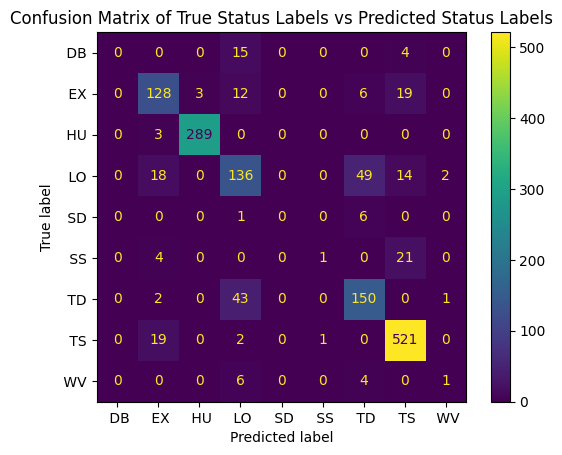

In [14]:
svc_cm = confusion_matrix(y_test_svc, predict, labels=svc_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=svc_cm, display_labels=svc_model.classes_)

disp.plot()
plt.title('Confusion Matrix of True Status Labels vs Predicted Status Labels')
plt.show()